# Multi-product SARIMA analysis (statsmodels fallback)

Requirements: `numpy`, `pandas`, `statsmodels`, `scikit-learn`, `matplotlib`, `seaborn`.

Note: Install packages in your activated virtual environment (recommended) rather than running installs inline in the notebook.

In [ ]:
# Install plotting packages in your environment if missing:
# python -m pip install matplotlib seaborn

In [ ]:
# # Install statsmodels into the kernel's Python (runs pip in the same interpreter)
# import sys, subprocess
# subprocess.check_call([sys.executable, "-m", "pip", "install", "statsmodels"])

In [11]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.statespace.sarimax import SARIMAX
from tqdm.notebook import tqdm  # Progress bar for notebook

In [12]:
# Load CSV with proper NaN handling
# csv_path = 'consolidated_file_cleaned_v1.csv'
# csv_path = 'sample.csv'
csv_path = 'consolidated_file_cleaned_v1_trimmed_by_product_ids_0pct.csv'
df = pd.read_csv(csv_path, na_values=['', ' ', 'NaN'])

In [13]:
# Clean column headers: remove special chars, whitespace, and rename
def clean_col(col):
    col = re.sub(r'\(.*?\)', '', col)  # Remove anything in parentheses
    col = re.sub(r'[^a-zA-Z0-9_ ]', '', col)  # Remove non-alphanumeric except underscore and space
    col = col.strip().replace(' ', '_').lower()
    # Only rename sold/month(₱) to sold_monthly (actual revenue)
    if col in ['sold_month', 'sold_monthly', 'soldmonth', 'sold/month', 'soldmonth₱', 'sold_month₱', 'sold/month₱']:
        return 'sold_monthly'
    if col == 'soldmonth₱' or col == 'sold_month₱' or col == 'sold/month₱':
        return 'sold_monthly'
    if col == 'time':
        return 'date'
    return col
df.columns = [clean_col(c) for c in df.columns]
print('Columns after cleaning:', df.columns.tolist())

Columns after cleaning: ['product', 'date', 'avgsku_price', 'soldday', 'revenueday', 'soldm', 'product_sales_rate', 'price', 'sku', 'sold', 'sold_monthly', 'revenuemonth', 'new_ratings', 'ratings', 'ratings_rate', 'likes', 'rating_star', 'new_likes', 'id', 'toplevel_category', 'seller_from', 'listing_time', 'active_months', 'suitable_for_seasonal_analysis']


No Batch Processing Fitting

In [14]:
# Detect product ID column robustly
product_id_col = None
for col in df.columns:
    if col in ['product_id', 'id', 'productid', 'prod_id', 'prodid']:
        product_id_col = col
        break
if not product_id_col:
    # Fallback: use 'id' if present, else use 'product' (not ideal, but better than nothing)
    if 'id' in df.columns:
        product_id_col = 'id'
    elif 'product' in df.columns:
        product_id_col = 'product'
if not product_id_col:
    pass  # No product ID column found
else:
    # SARIMA analysis loop with 70/20/10 split (robust univariate input)
    from collections import defaultdict
    results_dict = {}
    predictions_dict = defaultdict(dict)  # {product_id: {'val': (y_true, y_pred), 'test': (y_true, y_pred)}}
    product_groups = list(df.groupby(product_id_col))
    for product_id, group in tqdm(product_groups, desc='Fitting SARIMA models (split)'):
        sales_col = 'sold_monthly'
        if sales_col not in group.columns:
            continue
        sales_cols = [c for c in group.columns if c == sales_col]
        sales = group[['date'] + sales_cols].copy()
        if len(sales_cols) > 1:
            sales[sales_col] = pd.to_numeric(sales[sales_cols[0]], errors='coerce').fillna(0)
        else:
            sales[sales_col] = pd.to_numeric(sales[sales_col], errors='coerce').fillna(0)
        sales = sales.loc[:, ~sales.columns.duplicated()]
        sales['date'] = pd.to_datetime(sales['date'])
        sales = sales.groupby('date').sum()
        all_months = pd.date_range(start=sales.index.min(), end=sales.index.max(), freq='MS')
        sales = sales.reindex(all_months, fill_value=0)
        monthly_sales = sales[sales_col]
        nonzero_months = monthly_sales[monthly_sales > 0]
        if len(nonzero_months) < 12:
            continue
        # Chronological split
        n = len(monthly_sales)
        train_end = int(n * 0.7)
        val_end = int(n * 0.9)
        train = monthly_sales.iloc[:train_end]
        val = monthly_sales.iloc[train_end:val_end]
        test = monthly_sales.iloc[val_end:]
        if len(train) < 12 or len(val) < 1 or len(test) < 1:
            continue
        try:
            model = SARIMAX(train, order=(1,1,1), seasonal_order=(1,1,1,12))
            results = model.fit(disp=False)
            results_dict[product_id] = results
            # Forecast for validation
            val_forecast = results.get_forecast(steps=len(val))
            val_pred = val_forecast.predicted_mean
            predictions_dict[product_id]['val'] = (val.values, val_pred.values)
            # Refit on train+val for test forecast
            model_full = SARIMAX(monthly_sales.iloc[:val_end], order=(1,1,1), seasonal_order=(1,1,1,12))
            results_full = model_full.fit(disp=False)
            test_forecast = results_full.get_forecast(steps=len(test))
            test_pred = test_forecast.predicted_mean
            predictions_dict[product_id]['test'] = (test.values, test_pred.values)
        except Exception as e:
            continue

Fitting SARIMA models (split):   0%|          | 0/83 [00:00<?, ?it/s]

c:\Users\Ven\Documents\Coding\pambihira\CRAZY\poop\ShopeeAnalysis_Amalgam\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\Ven\Documents\Coding\pambihira\CRAZY\poop\ShopeeAnalysis_Amalgam\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\Ven\Documents\Coding\pambihira\CRAZY\poop\ShopeeAnalysis_Amalgam\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive paramete

### RMSE and MAPE for Validation and Test Sets
This cell computes RMSE and MAPE for each product's validation and test sets using the predictions from the previous cell.

In [15]:
import numpy as np
import pandas as pd

def rmse(y_true, y_pred):
    return np.sqrt(np.mean((np.array(y_true) - np.array(y_pred)) ** 2))

def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mask = y_true != 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100 if np.any(mask) else np.nan

metrics = []
for pid, preds in predictions_dict.items():
    val_true, val_pred = preds.get('val', ([], []))
    test_true, test_pred = preds.get('test', ([], []))
    metrics.append({
        'product_id': pid,
        'val_rmse': rmse(val_true, val_pred) if len(val_true) else np.nan,
        'val_mape': mape(val_true, val_pred) if len(val_true) else np.nan,
        'test_rmse': rmse(test_true, test_pred) if len(test_true) else np.nan,
        'test_mape': mape(test_true, test_pred) if len(test_true) else np.nan,
    })
metrics_df = pd.DataFrame(metrics)
display(metrics_df.head(10))

,product_id,val_rmse,val_mape,test_rmse,test_mape
0,723497775,8.952994e+06,2.222222e+01,1.931279e-02,1.016804e-07
1,1203013267,2.432062e+04,7.350807e+00,8.377177e+03,2.761506e+00
2,1980004362,7.545122e+05,4.441305e+01,0.000000e+00,0.000000e+00
3,2205898189,4.205217e+03,2.957738e-01,5.010353e+05,5.302157e+01
4,3128534484,4.201052e+04,2.857303e+02,8.595868e+03,6.116795e+01
5,3544503750,1.191762e+03,7.031670e-01,1.442802e-01,1.106925e-04
6,4106120823,1.846409e+06,3.288432e+02,1.175862e+06,1.523058e+02
7,4678699612,1.317342e-09,1.900504e-12,0.000000e+00,0.000000e+00
8,5934793519,1.784294e+04,6.379920e+00,6.810080e+04,2.277444e+01
9,6164330951,6.616195e+00,4.372135e-03,6.638614e+04,5.016029e+01


### Confusion Matrix Metrics for Sales Threshold
This cell computes confusion matrix metrics (TP, FP, TN, FN) for each product's test set, using a sales threshold (e.g., >0 means "positive"). Adjust the threshold as needed.

In [16]:
# Set threshold for positive sales (e.g., >0 means "positive")
sales_threshold = 0

confusion_metrics = []
for pid, preds in predictions_dict.items():
    test_true, test_pred = preds.get('test', ([], []))
    if len(test_true) == 0:
        continue
    y_true_bin = np.array(test_true) > sales_threshold
    y_pred_bin = np.array(test_pred) > sales_threshold
    tp = np.sum((y_true_bin == 1) & (y_pred_bin == 1))
    tn = np.sum((y_true_bin == 0) & (y_pred_bin == 0))
    fp = np.sum((y_true_bin == 0) & (y_pred_bin == 1))
    fn = np.sum((y_true_bin == 1) & (y_pred_bin == 0))
    confusion_metrics.append({
        'product_id': pid,
        'TP': tp,
        'FP': fp,
        'TN': tn,
        'FN': fn,
        'Precision': tp / (tp + fp) if (tp + fp) > 0 else np.nan,
        'Recall': tp / (tp + fn) if (tp + fn) > 0 else np.nan,
        'F1': 2 * tp / (2 * tp + fp + fn) if (2 * tp + fp + fn) > 0 else np.nan
    })
confusion_df = pd.DataFrame(confusion_metrics)
display(confusion_df.head(10))

,product_id,TP,FP,TN,FN,Precision,Recall,F1
0,723497775,5,0,0,0,1.0,1.0,1.0
1,1203013267,5,0,0,0,1.0,1.0,1.0
2,1980004362,5,0,0,0,1.0,1.0,1.0
3,2205898189,5,0,0,0,1.0,1.0,1.0
4,3128534484,5,0,0,0,1.0,1.0,1.0
5,3544503750,5,0,0,0,1.0,1.0,1.0
6,4106120823,0,0,0,5,NaN,0.0,0.0
7,4678699612,5,0,0,0,1.0,1.0,1.0
8,5934793519,5,0,0,0,1.0,1.0,1.0
9,6164330951,5,0,0,0,1.0,1.0,1.0


### Summary Plots for Metrics
This cell visualizes the distribution of RMSE, MAPE, and F1 scores across products.

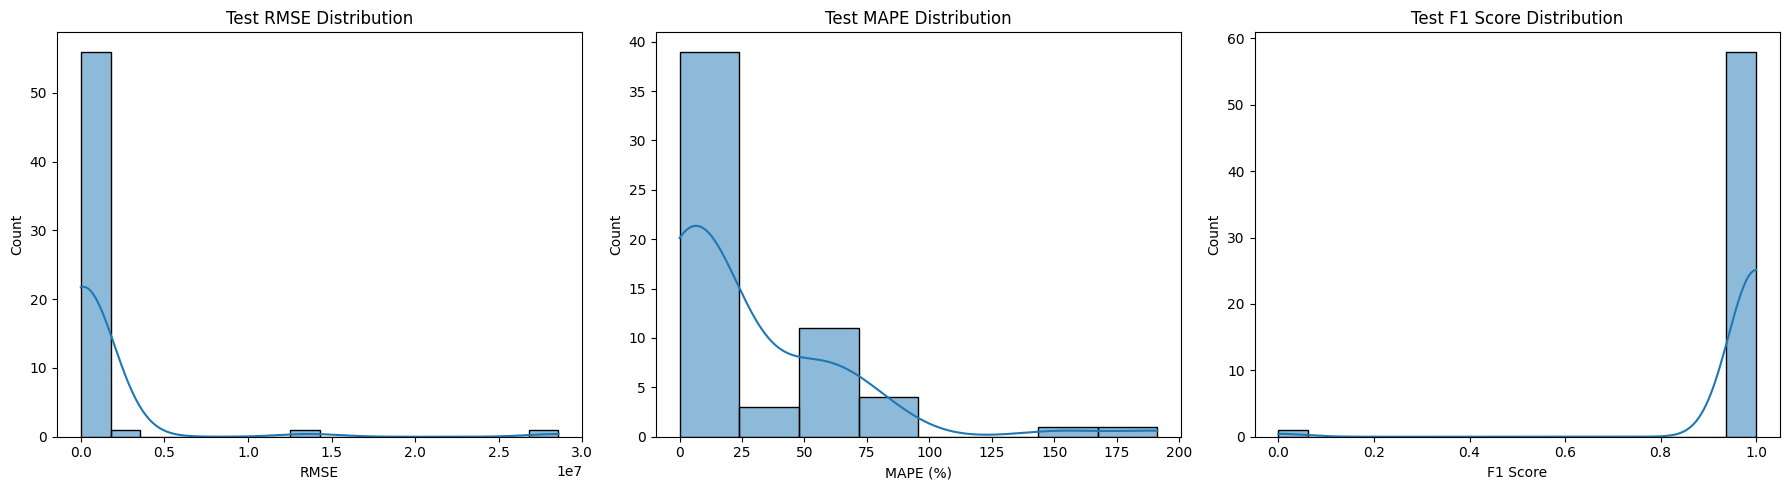

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sns.histplot(metrics_df['test_rmse'].dropna(), ax=axes[0], kde=True)
axes[0].set_title('Test RMSE Distribution')
axes[0].set_xlabel('RMSE')

sns.histplot(metrics_df['test_mape'].dropna(), ax=axes[1], kde=True)
axes[1].set_title('Test MAPE Distribution')
axes[1].set_xlabel('MAPE (%)')

sns.histplot(confusion_df['F1'].dropna(), ax=axes[2], kde=True)
axes[2].set_title('Test F1 Score Distribution')
axes[2].set_xlabel('F1 Score')

plt.tight_layout()
plt.show()

## Visualize SARIMA Results for a Selected Product

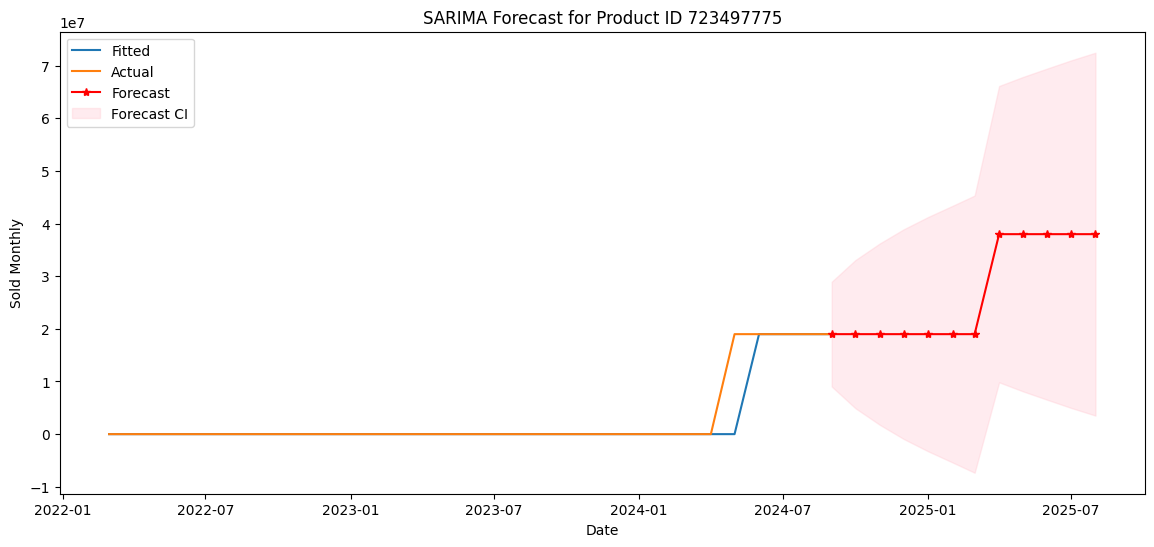

In [18]:
# Change index to visualize other products
selected_pid = list(results_dict.keys())[0] if results_dict else None
if selected_pid:
    res = results_dict[selected_pid]
    plt.figure(figsize=(14,6))
    # Plot the fitted values (in-sample prediction)
    plt.plot(res.fittedvalues.index, res.fittedvalues, label='Fitted')
    # Plot the actuals (if available)
    if hasattr(res.model.data, 'endog') and hasattr(res.model.data, 'row_labels'):
        plt.plot(res.model.data.row_labels, res.model.data.endog, label='Actual')
    # Forecast the next 12 months
    forecast = res.get_forecast(steps=12)
    forecast_index = pd.date_range(res.data.dates[-1], periods=12, freq='MS')
    plt.plot(forecast_index, forecast.predicted_mean, 'r*-', label='Forecast')
    conf_int = forecast.conf_int()
    plt.fill_between(forecast_index, conf_int.iloc[:,0], conf_int.iloc[:,1], color='pink', alpha=0.3, label='Forecast CI')
    plt.legend()
    plt.title(f'SARIMA Forecast for Product ID {selected_pid}')
    plt.ylabel('Sold Monthly')
    plt.xlabel('Date')
    plt.show()
else:
    print('No products with valid SARIMA results.')

## Summary Table of RMSE and MAPE for All Products

In [19]:
# Example: Summary table of AIC for all products (since RMSE and MAPE are not available by default)
import pandas as pd
summary = pd.DataFrame([
    {'id': pid, 'aic': res.aic}
    for pid, res in results_dict.items()
])
summary.sort_values('aic').head(10)  # Show top 10 products by AIC

,id,aic
21,11950615832,-372.628462
23,13032304534,-372.628462
55,25610351444,-372.628462
50,23747456492,-372.628462
48,23700226330,-372.628462
26,16003323508,298.674786
53,24763604980,342.759290
40,22206135422,342.912806
5,3544503750,343.723251
36,20243533839,387.964408


In [22]:
# --- Peak Demand Months and Top-Selling Products Analysis ---
# Forecast next 12 months for all products and store results
forecast_horizon = 12
product_forecasts = {}  # {product_id: pd.Series of forecasted sales}
for pid, res in results_dict.items():
    forecast = res.get_forecast(steps=forecast_horizon)
    forecast_index = pd.date_range(res.data.dates[-1], periods=forecast_horizon, freq='MS')
    product_forecasts[pid] = pd.Series(forecast.predicted_mean.values, index=forecast_index)

# 1. Peak demand months per product
peak_months_per_product = {}
for pid, forecast in product_forecasts.items():
    # Find the month(s) with the highest forecasted sales
    max_val = forecast.max()
    peak_months = forecast[forecast == max_val].index.strftime('%Y-%m').tolist()
    peak_months_per_product[pid] = peak_months

peak_months_df = pd.DataFrame([
    {'product_id': pid, 'peak_months': ', '.join(months)}
    for pid, months in peak_months_per_product.items()
])
print('Peak demand months per product:')
display(peak_months_df.head())

# 2. Top-selling products for a given month
input_month = '2026-01'  # Change this to the month you want to analyze (format: YYYY-MM)
top_products = []
for pid, forecast in product_forecasts.items():
    # Find forecast for the input month
    val = forecast.get(pd.to_datetime(input_month), None)
    if val is not None:
        top_products.append({'product_id': pid, 'forecasted_sales': val})
top_products_df = pd.DataFrame(top_products)
if not top_products_df.empty and 'forecasted_sales' in top_products_df.columns:
    top_products_df = top_products_df.sort_values('forecasted_sales', ascending=False)
    print(f'Top-selling products for {input_month}:')
    display(top_products_df.head(10))  # Show top 10 products for the selected month
else:
    print(f'No forecasted sales available for {input_month}.')

# 3. Input a product ID to see its forecasted peak months and monthly forecast
input_product_id = 23943860856  # Change this to the product ID you want to analyze
if input_product_id in product_forecasts:
    forecast = product_forecasts[input_product_id]
    print(f'Forecast for product {input_product_id}:')
    display(forecast)
    max_val = forecast.max()
    peak_months = forecast[forecast == max_val].index.strftime('%Y-%m').tolist()
    print(f'Peak demand month(s): {", ".join(peak_months)}')
else:
    print('Product ID not found in forecasts.')

Peak demand months per product:


,product_id,peak_months
0,723497775,"2025-04, 2025-05, 2025-06, 2025-07, 2025-08"
1,1203013267,2025-02
2,1980004362,"2025-02, 2025-03, 2025-04, 2025-05, 2025-06, 2..."
3,2205898189,2025-06
4,3128534484,2024-09


No forecasted sales available for 2026-01.
Forecast for product 23943860856:


2024-09-01    3445181.0
2024-10-01    3445181.0
2024-11-01    3445181.0
2024-12-01    3445181.0
2025-01-01    3445181.0
2025-02-01    3445181.0
2025-03-01    3445181.0
2025-04-01    3445181.0
2025-05-01    3445181.0
2025-06-01    3445181.0
2025-07-01    3445181.0
2025-08-01    6890362.0
Freq: MS, dtype: float64

Peak demand month(s): 2025-08


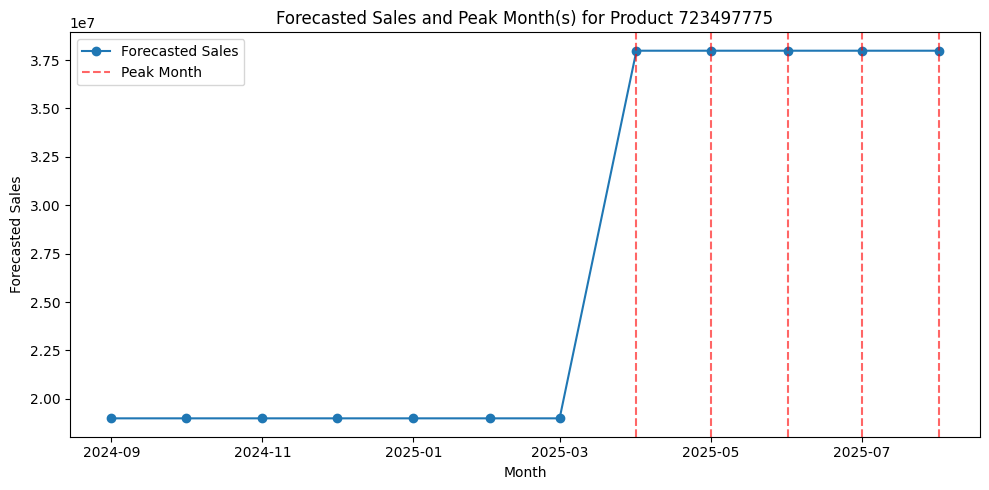

No top products data available for visualization.


In [23]:
# --- Visualization for Peak Demand and Top Products ---
import matplotlib.pyplot as plt

# 1. Visualize peak demand months for a selected product
selected_pid = list(product_forecasts.keys())[0] if product_forecasts else None  # Change as needed
if selected_pid:
    forecast = product_forecasts[selected_pid]
    plt.figure(figsize=(10, 5))
    plt.plot(forecast.index, forecast.values, marker='o', label='Forecasted Sales')
    max_val = forecast.max()
    peak_months = forecast[forecast == max_val].index
    for peak in peak_months:
        plt.axvline(peak, color='red', linestyle='--', alpha=0.6, label='Peak Month' if peak == peak_months[0] else None)
    plt.title(f'Forecasted Sales and Peak Month(s) for Product {selected_pid}')
    plt.xlabel('Month')
    plt.ylabel('Forecasted Sales')
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print('No product forecasts available for visualization.')

# 2. Visualize top-selling products for the selected month
try:
    top_products_df
except NameError:
    print('No top products data available for visualization.')
else:
    if not top_products_df.empty and 'forecasted_sales' in top_products_df.columns:
        plt.figure(figsize=(12, 5))
        plt.bar(top_products_df['product_id'].astype(str)[:10], top_products_df['forecasted_sales'][:10], color='skyblue')
        plt.title(f'Top 10 Products for {input_month}')
        plt.xlabel('Product ID')
        plt.ylabel('Forecasted Sales')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
    else:
        print('No top products data available for visualization.')